Theses Project Experiment with ResNet-50 Model

Submitted by Himanshu Gupta

In [4]:
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot

# Data Processing 
import os
import os.path
import random
import PIL
import glob
from PIL import Image # to read images


In [6]:
# For Data Spltting
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [7]:
#For Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, LSTM
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Dataset Path 

In [10]:
# Initial Dataset Path
initial_data_path = "/content/drive/My Drive/data/"
initial_data_csv_path = "/content/drive/My Drive/InitialData.csv"

# Augmented Data Path
data_path = "/content/drive/My Drive/trainDataTACO/"
final_data_csv_path = "/content/drive/My Drive/FinalData.csv"

### keras VGG19 Initialisation

In [11]:
# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (128, 128, 3), classes = 5)

80142336/80134624 [==============================] - 0s 0us/step


In [12]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

Generic CNN model on top of VGG

In [13]:
def create_model(input_shape):
  classifier = Sequential()
  classifier.add(Dense(16, activation='relu', input_dim=input_shape))
  classifier.add(BatchNormalization())
  classifier.add(Dropout(0.5))
  #
  classifier.add(Flatten())
  classifier.add(Dropout(0.5))
  classifier.add(Dense(5, activation='softmax'))
  classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return classifier 

In [14]:
# Early callback Parameter
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 20)

In [15]:
def create_data(df , path):
  train_data = []  
  for ind in df.index:
      img=Image.open(os.path.join(path+ df['filename'][ind]))
      img = img.resize((128, 128), Image.ANTIALIAS)
      img = image.img_to_array(img)
      # Append image
      train_data.append(img)

  # Create data arrays
  X = np.array(train_data)
  # Create dummy variables
  df = pd.get_dummies(df, columns=["category"])
  y = np.array(df.drop(['filename'],axis=1))

  # Here I split original training data to sub-training (80%) and testing data (20%)
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size=0.2, stratify=y)

  return (X_train, X_test, y_train, y_test)

**Data Creation for model 1**

In [ ]:
df1 = pd.read_csv(initial_data_csv_path)
df1 = df1.drop(['x_min','x_max','y_min','y_max'], axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  805 non-null    object
 1   category  805 non-null    object
dtypes: object(2)
memory usage: 12.7+ KB


In [ ]:
# Create Data   
print("Generating data........")
(X_train, X_test, y_train, y_test) = create_data(df1 ,initial_data_path)
# Check the data size whether it is as per tensorflow and VGG19 requirement
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Preprocessing the input 
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# Extracting features
train_features = vgg19.predict(np.array(X_train), batch_size=50, verbose=0)
test_features = vgg19.predict(np.array(X_test), batch_size=50, verbose=0)
# Current shape of features
print(train_features.shape, "\n",  test_features.shape)
input_shape = (train_features.shape[1]*train_features.shape[2]*train_features.shape[3])
# Flatten extracted features
train_features = np.reshape(train_features, (train_features.shape[0], input_shape))
test_features = np.reshape(test_features, (test_features.shape[0], input_shape))

Generating data........
(644, 4, 4, 512) 
 (161, 4, 4, 512)


In [ ]:
print("Model 1 training.........")
# Create Model Object
model_1 = create_model(input_shape)
model_1.summary()

# Train the the model
history = model_1.fit(train_features, y_train, batch_size=50, epochs=100, verbose=1, validation_split=0.2, callbacks = [cb_early_stopper])
print("Model 1 training Completed")

Model 1 training.........
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                131088    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 85        
Total params: 131,237
Trainable params: 131,205
Non-trainable params: 32
_____________________

In [ ]:
# Evaluate the model 1
_, train_acc = model_1.evaluate(train_features, y_train)
_, test_acc = model_1.evaluate(test_features, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

6/6 [==============================] - 0s 6ms/step - loss: 1.4373 - accuracy: 0.3913
Train: 0.797, Test: 0.391


## **Model 2 creation on Augmented Data**

In [17]:
df2 = pd.read_csv(final_data_csv_path)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3442 entries, 0 to 3441
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  3442 non-null   object
 1   filename  3442 non-null   object
dtypes: object(2)
memory usage: 53.9+ KB


In [14]:
# Create Data   
print("Generating input features for model 2........")
(x_train, x_test, y_train, y_test) = create_data(df2 ,data_path)

# Preprocessing the input 
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

# Extracting features
train_features = vgg19.predict(np.array(x_train), batch_size=50, verbose=0)
test_features = vgg19.predict(np.array(x_test), batch_size=50, verbose=0)

print(train_features.shape)
print(test_features.shape)
input_shape = (train_features.shape[1]*train_features.shape[2]*train_features.shape[3])
# Flatten extracted features
train_features = np.reshape(train_features, (train_features.shape[0], input_shape))
test_features = np.reshape(test_features, (test_features.shape[0], input_shape))

Generating input features for model 2........
(2753, 4, 4, 512)
(689, 4, 4, 512)


In [ ]:
print("Model 2 training.........")
# Create Model Object
model_2 = create_model(input_shape)
model_2.summary()

# Train the the model
history = model_2.fit(train_features, y_train, batch_size=50, epochs=100, verbose=1, validation_split=0.2, callbacks = [cb_early_stopper])
print("Model 2 training Completed")

Model 2 training.........
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                131088    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 85        
Total params: 131,237
Trainable params: 131,205
Non-trainable params: 32
_____________________

22/22 [==============================] - 0s 3ms/step - loss: 0.4435 - accuracy: 0.8650
Train: 0.963, Test: 0.865


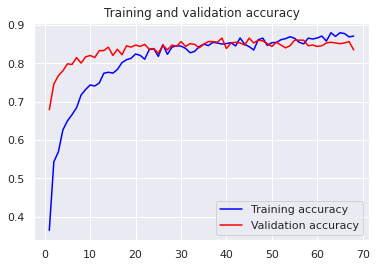

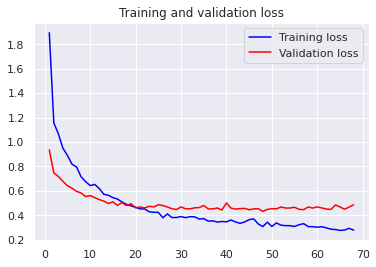

In [ ]:
# Evaluate the model 1
_, train_acc = model_2.evaluate(train_features, y_train)
_, test_acc = model_2.evaluate(test_features, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot the loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'red', label='Validation accuracy')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')

plt.legend()

plt.show()

## **Cross Validation K-FOLD**

In [18]:
(x_train, x_test, y_train, y_test) = create_data(df2 ,data_path)

In [19]:
# Preprocessing the input 
x_train1 = preprocess_input(x_train)
x_test1 = preprocess_input(x_test)

In [20]:
def create_model_k():
  kfold_model = Sequential()
  kfold_model.add(VGG19(include_top = False, pooling = 'avg', weights = 'imagenet')) 
  # Second layer added for dropout
  kfold_model.add(keras.layers.Dropout(0.3))
  # Third layer as Dense for output 5-class classification
  kfold_model.add(Dense(5, activation = 'softmax'))
  # No need to train first layer (ResNet) model as it is already trained
  kfold_model.layers[0].trainable = False
  kfold_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return kfold_model

In [21]:
model_k = KerasClassifier(build_fn = create_model_k, epochs=50, batch_size=50, verbose=1)
kfold = KFold(n_splits=5, shuffle=True, random_state=13)
results = cross_val_score(model_k, x_train, y_train, cv = kfold, verbose=10, n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  7.4min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.4min finished


In [22]:
results

array([0.81669694, 0.85117966, 0.81669694, 0.78181821, 0.81818181])

In [23]:
results.mean()

0.8169147133827209